# Predicting Individual IMFs with MLP Networks

In [1]:
from pathlib import Path

import gsod
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

gsod.enable_svg_graphing()
gsod.suppress_tf_log()

Init Plugin
Init Graph Optimizer
Init Kernel


Load dataset.

In [2]:
STATION = "722860"
ds = gsod.GsodDataset("runtime/GSOD")
filled = ds.read_continuous(stn=STATION, year="????", fill="ffill")
filled.describe().T

,count,mean,std,min,25%,50%,75%,max
STN,32354.0,722860.000000,0.000000,722860.0,722860.0,722860.0,722860.0,722860.00
WBAN,32354.0,27460.341411,17746.121157,23119.0,23119.0,23119.0,23119.0,99999.00
TEMP,32354.0,62.576949,11.061889,31.1,53.9,61.5,71.3,105.40
TEMP_COUNT,32354.0,23.368053,2.851843,4.0,24.0,24.0,24.0,24.00
DEWP,32354.0,377.128723,1790.849275,-14.4,37.9,46.5,53.0,9999.90
DEWP_COUNT,32354.0,23.054305,4.409794,0.0,24.0,24.0,24.0,24.00
SLP,32354.0,1108.205622,910.893861,994.3,1012.1,1014.4,1017.6,9999.90
SLP_COUNT,32354.0,18.957223,7.220772,0.0,8.0,24.0,24.0,24.00
STP,32354.0,5616.034051,4517.678520,939.4,960.3,9999.9,9999.9,9999.90
STP_COUNT,32354.0,9.301817,10.872137,0.0,0.0,0.0,24.0,24.00


Load CEEMDAN decomposition results.
Run `10-EMD.ipynb` first if you havn't done so.

In [3]:
imfs_array = np.load("runtime/imfs.npy")
imfs = pd.DataFrame(imfs_array.T,
                    columns=[f"IMF_{n+1}" for n in range(len(imfs_array))])
imfs.index = filled.index
dataframe = pd.merge(filled, imfs, how="left",
                     left_index=True, right_index=True)
imfs.describe().T

,count,mean,std,min,25%,50%,75%,max
IMF_1,32354.0,-0.010340,1.449340,-7.619344,-0.938239,-0.025342,0.899610,7.341002
IMF_2,32354.0,-0.000747,0.229574,-1.875797,-0.148246,-0.002521,0.145563,2.381316
IMF_3,32354.0,-0.002395,1.173193,-6.156962,-0.738183,-0.009680,0.719782,5.661657
IMF_4,32354.0,-0.007666,1.719410,-9.039261,-1.152785,-0.019758,1.135773,9.464785
IMF_5,32354.0,-0.007829,1.716960,-7.320283,-1.198724,-0.029414,1.173112,6.880679
IMF_6,32354.0,-0.005997,1.588422,-5.901096,-1.145869,0.003485,1.116411,6.104618
IMF_7,32354.0,-0.002001,1.462827,-4.960854,-1.035433,-0.002021,1.058087,5.560264
IMF_8,32354.0,0.004411,1.175324,-4.410120,-0.801489,-0.004122,0.826098,4.923733
IMF_9,32354.0,-0.643285,6.861542,-13.713941,-6.492477,-1.907348,5.655253,14.311388
IMF_10,32354.0,-0.021887,2.876106,-7.440069,-2.291113,-0.036823,2.256935,6.821336


Specification for the MLP model, training parameters, and helper functions.

In [4]:
WIDTH = 7
MAX_EPOCHS = 100
N_BATCH = 64
# Features other than the IMF
# "DEWP", , "STP", "VISIB", "WDSP", "MXSPD", "GUST", "MAX", "MIN", "PRCP", "SNDP"
OTHER_FEATURES = []


def build_compile_model() -> tf.keras.Model:
    """Specify and compile a model."""
    input_layer = tf.keras.Input(
        # Enable to use stateful model
        # batch_shape=(N_BATCH, WIDTH, len(OTHER_FEATURES) + 1)
        shape=(WIDTH, len(OTHER_FEATURES) + 1)
    )
    mlp = tf.keras.layers.Dense(128)(input_layer)
    mlp = tf.keras.layers.Dense(128)(mlp)
    mlp = tf.keras.layers.Dense(128)(mlp)
    mlp = tf.keras.layers.Dropout(0.2)(mlp)
    mlp = tf.keras.layers.Dense(64)(mlp)
    mlp = tf.keras.layers.Dense(1)(mlp)
    model = tf.keras.Model(inputs=input_layer, outputs=mlp)
    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError()]
    )
    return model


def fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        mode="min"
    )
    history = model.fit(
        window.train, epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
        verbose=0, shuffle = False
    )
    return history

In [5]:
val_performance = {}
performance = {}
save_path_template = "runtime/MLP_{imf_name}.h5"
no_reload = False

Train each IMFs with its own models. In my case, CPU is faster.

Training IMF_1Metal device set to: Apple M1

Validating IMF_1
101/101 [==============================] - 0s 2ms/step - loss: 1.9938 - mean_absolute_error: 1.1006
Testing IMF_1
Training IMF_2
Validating IMF_2
101/101 [==============================] - 0s 1ms/step - loss: 0.0501 - mean_absolute_error: 0.1735
Testing IMF_2
Training IMF_3
Validating IMF_3
101/101 [==============================] - 0s 1ms/step - loss: 0.8927 - mean_absolute_error: 0.7428
Testing IMF_3
Training IMF_4
Validating IMF_4
101/101 [==============================] - 0s 1ms/step - loss: 0.9105 - mean_absolute_error: 0.7744
Testing IMF_4
Training IMF_5
Validating IMF_5
101/101 [==============================] - 0s 1ms/step - loss: 0.3667 - mean_absolute_error: 0.4914
Testing IMF_5
Training IMF_6
Validating IMF_6
101/101 [==============================] - 0s 1ms/step - loss: 0.1161 - mean_absolute_error: 0.2773
Testing IMF_6
Training IMF_7
Validating IMF_7
101/101 [==============================] - 0s 1ms/step - loss:

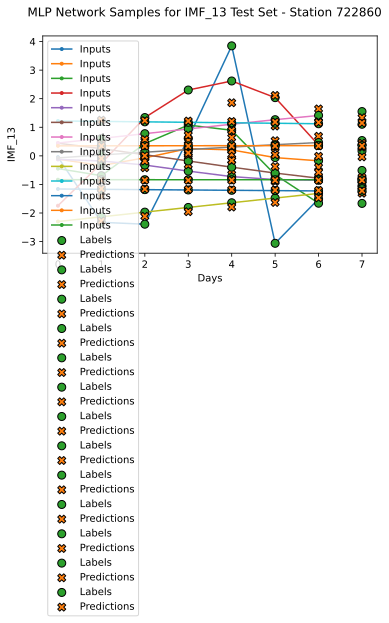

In [6]:
with tf.device("/cpu:0"):
    # Skip the last (trend) IMF
    for imf_name in (f"IMF_{n}" for n in range(1, len(imfs.T))):
        save_path = None
        if save_path_template is not None:
            save_path = Path(save_path_template.format(imf_name=imf_name))
        print(f"Training {imf_name}")
        wide_window = gsod.WindowGenerator(
            df=dataframe[[imf_name] + OTHER_FEATURES],
            input_width=WIDTH, label_width=WIDTH, shift=1,
            batch_size=N_BATCH, label_columns=[imf_name]
        )
        if save_path is not None and save_path.exists() and not no_reload:
            lstm_model = tf.keras.models.load_model(save_path)
        else:
            lstm_model = build_compile_model()
            fit(lstm_model, wide_window)
        print(f"Validating {imf_name}")
        val_performance[f"{imf_name}"] = lstm_model.evaluate(wide_window.val)
        print(f"Testing {imf_name}")
        performance[f"{imf_name}"] = lstm_model.evaluate(wide_window.test,
                                                         verbose=0)
        wide_window.plot(model=lstm_model, max_subplots=1, plot_col=imf_name,
                         dataset="test", network_name="MLP", station_name=STATION)
        if save_path is not None:
            lstm_model.save(save_path)
        tf.keras.backend.clear_session()

Show the metrics of the final result.

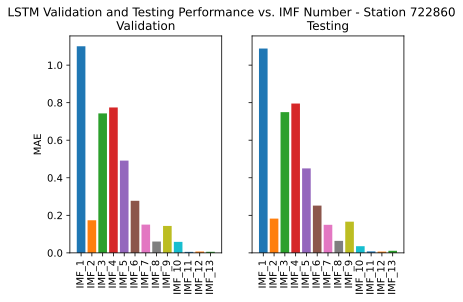

In [7]:
fig, ax = plt.subplots(1, 2, sharey=True)
plt.suptitle(f"LSTM Validation and Testing Performance vs. IMF Number "
             + f"- Station {STATION}")
ax[0].yaxis.label.set_text("MAE")
ax[0].title.set_text("Validation")
ax[0].tick_params("x", labelrotation=90)
for perf in val_performance.keys():
    ax[0].bar(perf, val_performance[perf][1])
ax[1].title.set_text("Testing")
ax[1].tick_params("x", labelrotation=90)
for perf in performance.keys():
    ax[1].bar(perf, performance[perf][1])

Save the metrics for comparison

In [8]:
import json
json.dump({"val": val_performance, "test": performance}, open("runtime/mlp_perf.json", "w"))